In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.lines import Line2D
from scipy.stats import beta as beta_dist
import pandas as pd
from tabulate import tabulate
import warnings
import seaborn as sns
import pickle
import os
import os.path as osp
from sklearn.calibration import calibration_curve
import pdb

In [3]:
%load_ext autoreload
%autoreload 2
from rankingFairness.src.experiment import simpleOffline
from rankingFairness.src.utils import set_seed, PlattCalibrator
from rankingFairness.src.rankings import PRP_Ranker, EO_Ranker, EO_RankerII, TS_RankerII, DP_Ranker, Uniform_Ranker, DP_RankerIII, DP_RankerIV
from rankingFairness.src.distributions import Bernoulli
from rankingFairness.src.tradeoff import UtilityCost


In [4]:
SEED=42
set_seed(SEED)

In [5]:
df_task_1_split = []
df_examples = pd.read_parquet('/home/rr568/ranking-fairness-uncertainty/esci-data/shopping_queries_dataset/shopping_queries_dataset_examples.parquet')
df_products = pd.read_parquet('/home/rr568/ranking-fairness-uncertainty/esci-data/shopping_queries_dataset/shopping_queries_dataset_products.parquet')
df_sources = pd.read_csv("/home/rr568/ranking-fairness-uncertainty/esci-data/shopping_queries_dataset/shopping_queries_dataset_sources.csv")
df_examples_products = pd.merge(
    df_examples,
    df_products,
    how='left',
    left_on=['product_locale','product_id'],
    right_on=['product_locale', 'product_id']
)

for i, split in enumerate(["train", "test"]):
    df_task_tmp = df_examples_products[df_examples_products["large_version"] == 1]
    df_task_1_split.append(df_task_tmp[df_task_tmp["split"] == f"{split}"])

In [6]:
assert len(df_task_1_split)==2

In [7]:
test_df_products_us = df_task_1_split[1].loc[df_task_1_split[1]['product_locale']=='us'].reset_index(drop=True)

In [8]:
test_df_products_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425762 entries, 0 to 425761
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   example_id            425762 non-null  int64 
 1   query                 425762 non-null  object
 2   query_id              425762 non-null  int64 
 3   product_id            425762 non-null  object
 4   product_locale        425762 non-null  object
 5   esci_label            425762 non-null  object
 6   small_version         425762 non-null  int64 
 7   large_version         425762 non-null  int64 
 8   split                 425762 non-null  object
 9   product_title         425762 non-null  object
 10  product_description   212036 non-null  object
 11  product_bullet_point  375464 non-null  object
 12  product_brand         405793 non-null  object
 13  product_color         297094 non-null  object
dtypes: int64(4), object(10)
memory usage: 45.5+ MB


In [9]:
ranking_probs = pd.read_csv('/home/rr568/ranking-fairness-uncertainty/esci-data/ranking/hypothesis/task_1_ranking_model_us.csv')
ranking_probs.reset_index(inplace=True)
ranking_probs.rename(columns={'index':'qp_pair_id'}, inplace=True)

In [10]:
Amazon_trademarked_brands = pd.read_csv("/home/rr568/ranking-fairness-uncertainty/investigation-amazon-brands/data/output/datasets/trademarks/amazon_trademarked_brands.csv")
Amazon_trademarked_brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Word Mark           158 non-null    object
 1   Goods and Services  133 non-null    object
 2   Filing Date         133 non-null    object
 3   Owner               133 non-null    object
dtypes: object(4)
memory usage: 5.1+ KB


In [11]:
AmazonBrands=Amazon_trademarked_brands['Word Mark'].str.lower().values
print(f"number of Amazon brands:{len(AmazonBrands)}")

number of Amazon brands:158


In [12]:
test_us_Amazon = test_df_products_us.loc[test_df_products_us['product_brand'].str.lower().isin(AmazonBrands)]
print(f"unique queries in the test split:{len(test_df_products_us['query_id'].unique())}")
Amazon_queries = test_us_Amazon['query_id'].unique()
print(f"unique queries that contain Amazon brand products:{len(Amazon_queries)}")

unique queries in the test split:22458
unique queries that contain Amazon brand products:2120


### map ESCI labels to binary relevances and relevance values

In [13]:
esci2binary_map={'E':1, 'S':0, 'C':0, 'I':0}
esci2weights_map={'E':1.0, 'S':0.1, 'C':0.01, 'I':0}
test_df_products_us['binary_rel'] = test_df_products_us['esci_label'].map(esci2binary_map)
test_df_products_us['rel_vals'] = test_df_products_us['esci_label'].map(esci2weights_map)

In [14]:
pd.testing.assert_frame_equal(test_us_Amazon, test_us_Amazon.loc[test_us_Amazon['query_id'].isin(Amazon_queries)])

### filter those queries that contain at least 3 products owned by Amazon

In [15]:
thresh_q=3
Amazon_queries_count = test_us_Amazon.groupby(['query_id'])['example_id'].count()
Amazon_queries_geq_3 = Amazon_queries_count[Amazon_queries_count>=thresh_q].index
print(f"num of queries with num of Amazon products >=3: {len(Amazon_queries_geq_3)}")

num of queries with num of Amazon products >=3: 411


In [16]:
Amazon_products_num = test_us_Amazon.groupby(['query_id'])['example_id'].count().values
print(f" % of queries with num of Amazon products >=3: {len(Amazon_products_num[Amazon_products_num>=thresh_q])*100/len(Amazon_products_num):.2f}%")
print(f" num of queries with Amazon products: {len(Amazon_products_num)}")
print(f" num of queries with num of Amazon product >=3: {len(Amazon_products_num[Amazon_products_num>=thresh_q])}")

 % of queries with num of Amazon products >=3: 19.39%
 num of queries with Amazon products: 2120
 num of queries with num of Amazon product >=3: 411


In [17]:
assert len(Amazon_queries_geq_3)==len(Amazon_products_num[Amazon_products_num>=thresh_q])

In [18]:
examples_w_Amazon = test_df_products_us.loc[test_df_products_us['query_id'].isin(Amazon_queries)]

### filter those queries that contain Amazon products but also contain at least 3 of the other products

In [19]:
queries_w_other = test_df_products_us.loc[test_df_products_us['query_id'].isin(Amazon_queries)]
groups_other = queries_w_other.loc[~queries_w_other['product_brand'].str.lower().isin(AmazonBrands)]
groups_other = groups_other.groupby(['query_id'])['example_id'].count()
queries_w_other_thresh = groups_other[groups_other>=thresh_q].index
print(f"num of queries with Amazon and with other products>={thresh_q}: {len(queries_w_other_thresh)}")

num of queries with Amazon and with other products>=3: 2104


In [20]:
master_queries_amazon = np.intersect1d(Amazon_queries_geq_3, queries_w_other_thresh)
print(f"num of queries num of amazon brand items >=3 and other items >=3: {len(master_queries_amazon)}")

num of queries num of amazon brand items >=3 and other items >=3: 395


In [21]:
queries_product_id_count = test_df_products_us.groupby(['query_id'])['example_id'].count().reset_index()
queries_esci_only_I = test_df_products_us.groupby(['query_id','esci_label'])['example_id'].count().reset_index()
queries_esci_only_I = queries_esci_only_I.loc[queries_esci_only_I['esci_label']=='I']
queries_esci_only_I_merged = queries_product_id_count.merge(queries_esci_only_I, left_on='query_id',
                                                            right_on='query_id')
queries_esci_only_I_merged['diff']=queries_esci_only_I_merged['example_id_x']-queries_esci_only_I_merged['example_id_y']
queries_esci_I = queries_esci_only_I_merged.loc[queries_esci_only_I_merged['diff']==0]
print(f" number of queries that only contain irrelevant products:{len(queries_esci_I)}")

 number of queries that only contain irrelevant products:0


### divide filtered queries into calibration and test dataset

In [22]:
#divide queries into cal and test
cal_idx = np.random.choice(len(master_queries_amazon), int(len(master_queries_amazon)*0.5),
                           replace=False)
test_idx = np.setdiff1d(np.arange(len(master_queries_amazon)), cal_idx)
assert len(np.intersect1d(cal_idx, test_idx))==0
cal_queries = master_queries_amazon[cal_idx]
test_queries = master_queries_amazon[test_idx]

In [23]:
examples_w_Amazon = test_df_products_us.loc[test_df_products_us['query_id'].isin(master_queries_amazon)]
print(f" number of examples in cal and test: {len(examples_w_Amazon)}")


 number of examples in cal and test: 9362


### transform logit scores from Amazon's baseline model to probabilities with sigmoid

In [24]:
# get the probabilities for ranking
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [25]:
ranking_probs_tmp = ranking_probs.copy()
ranking_probs_tmp['scores']=ranking_probs_tmp['scores'].apply(lambda x: sigmoid(x))
test_df_products_us =  test_df_products_us.merge(ranking_probs_tmp[['example_id', 'scores']], left_on='example_id', right_on='example_id')

In [26]:
assert len(examples_w_Amazon.loc[examples_w_Amazon['large_version']==1]) == len(examples_w_Amazon)

In [27]:
Amazon_brands_map={}
print(f"num of Amazon brands: {len(AmazonBrands)}")
for b in AmazonBrands:
    Amazon_brands_map[b]='amazon'

num of Amazon brands: 158


In [28]:

def plotCalibrationPlots(predProbs, y_true, n_bins=20):
    fig, ax =plt.subplots(nrows=2, figsize=(5,10))
    prob_true, prob_pred = calibration_curve(y_true, predProbs, n_bins=n_bins, strategy='quantile')
    ax[0].plot([min(prob_true.min(), prob_pred.min()),max(prob_true.max(), prob_pred.max())],[min(prob_true.min(), prob_pred.min()), max(prob_true.max(), prob_pred.max())], linestyle='--', color='black')
    ax[0].scatter(prob_pred, prob_true, s=15)
    ax[0].set_xlabel('Mean predicted rate', fontsize=15)
    ax[0].set_ylabel('Mean empirical rate', fontsize=15)
    ax[0].tick_params(axis='y', labelsize=10)
    ax[0].tick_params(axis='x', labelsize=10)
    ax[1].hist(predProbs, bins=n_bins)
    ax[1].set_xlabel('Mean predicted probability')
    ax[1].set_ylabel('Counts')
    plt.show()

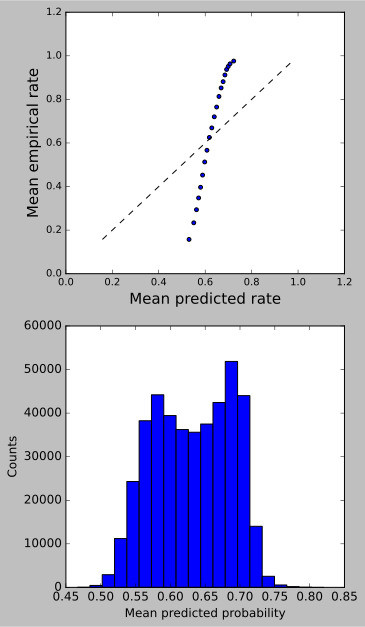

In [29]:
plotCalibrationPlots(np.array(test_df_products_us['scores'].values)
                    , np.array(test_df_products_us['binary_rel'].values), n_bins=20)

### form calibration and test dataframe

In [30]:
df_cal = test_df_products_us.loc[test_df_products_us['query_id'].isin(cal_queries)]
df_test = test_df_products_us.loc[test_df_products_us['query_id'].isin(test_queries)]

### fit the Platt Calibrator groupwise for both Amazon and other products on the calibration dataset

In [31]:
platt = PlattCalibrator(log_odds=True)
df_cal_Amazon = df_cal.loc[df_cal['product_brand'].str.lower().isin(AmazonBrands)]
df_cal_other = df_cal.loc[~df_cal['product_brand'].str.lower().isin(AmazonBrands)]
platt.fit(df_cal_Amazon['scores'].values, df_cal_Amazon['binary_rel'].values)
platt.fit(df_cal_other['scores'].values, df_cal_other['binary_rel'].values)



PlattCalibrator()

### filter the test dataset with Amazon and other dataframe

In [32]:
df_test_Amazon = df_test.loc[df_test['product_brand'].str.lower().isin(AmazonBrands)]
df_test_other = df_test.loc[~df_test['product_brand'].str.lower().isin(AmazonBrands)]

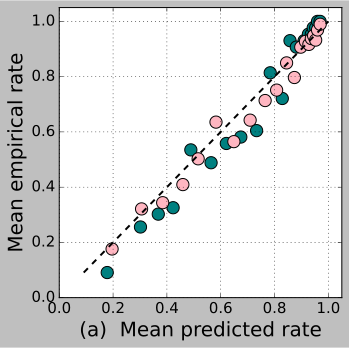

In [63]:
fig, ax =plt.subplots(figsize=(5,5))
offset=0.05
n_bins=20

y_prob=platt.predict(df_test_Amazon['scores'].values)
prob_true, prob_pred = calibration_curve(df_test_Amazon['binary_rel'].values, y_prob , n_bins=n_bins, strategy='quantile')
quantiles = np.linspace(0, 1, n_bins + 1)
bins = np.percentile(y_prob, quantiles * 100)
ax.plot([min(prob_true.min(), prob_pred.min()),max(prob_true.max(), prob_pred.max())],[min(prob_true.min(), prob_pred.min()), max(prob_true.max(), prob_pred.max())],
        linestyle='--', color='black', linewidth=2, label="Perfect calibration")
ax.scatter(prob_pred, prob_true, s=150, c='teal', label='Amazon (group A)')

y_prob_other=platt.predict(df_test_other['scores'].values)
prob_true_other, prob_pred_other = calibration_curve(df_test_other['binary_rel'].values, y_prob_other, n_bins=n_bins, strategy='quantile')
quantiles_other = np.linspace(0, 1, n_bins + 1)
bins_other = np.percentile(y_prob_other, quantiles_other * 100)
ax.scatter(prob_pred_other, prob_true_other, s=150, c='lightpink', label='Non-Amazon (group B)')


ax.set_xlabel('(a)  Mean predicted rate', fontsize=20)
ax.set_ylabel('Mean empirical rate', fontsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

handles, labels = ax.get_legend_handles_labels()
eor_handle = Line2D([], [], c='tab:red', linestyle='solid', linewidth=3, label=r'EOR Ranking')
logged_r_handle = Line2D([], [], c='purple', linestyle='solid', linewidth=3, label=r'Logged Ranking')
handles.extend([eor_handle, logged_r_handle])
# legend=plt.legend(handles=handles, fontsize=12, loc='upper center', 
#         bbox_to_anchor=(0.5, 1.35),
#         ncol=3, numpoints=1, scatterpoints=1)
# bbox=legend.get_window_extent()
# expand=[-5,-5,5,5]
# bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
# bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
# plt.savefig(f"{osp.join('/share/thorsten/rr568/CostOptimal_FairRankings/plots/esci','legend.pdf')}", bbox_inches=bbox)
ax.set_xlim(0.0, 1.0+offset)
ax.set_ylim(0.0, 1.0+offset)
plt.grid()
plt.tight_layout()
plt.savefig(f"{osp.join('/share/thorsten/rr568/CostOptimal_FairRankings/plots/esci','calibration.pdf')}", bbox_inches='tight')
plt.show()
plt.close()

### form a column 'calibrated_probs' for the test dataframe

In [ ]:
df_test['calibrated_prob'] = platt.predict(df_test['scores'].values)

In [35]:
print(f"number of test queries that the dataset was verified calibration on :{len(np.unique(df_test['query_id'].values))}")
print(f"number of val queries that the dataset was calibrated on :{len(np.unique(df_cal['query_id'].values))}")

number of test queries that the dataset was verified calibration on :198
number of val queries that the dataset was calibrated on :197


## Markup Data

In [36]:
# load the df_search from markup
df_markup=pd.read_csv('/share/thorsten/rr568/AmazonSearchQuery/df_search.csv', sep='\t')
df_markup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248939 entries, 0 to 248938
Data columns (total 36 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 248939 non-null  int64  
 1   asin                       248939 non-null  object 
 2   product_name               248939 non-null  object 
 3   stars                      240197 non-null  float64
 4   reviews                    240197 non-null  float64
 5   brand                      43312 non-null   object 
 6   product_url                248939 non-null  object 
 7   is_prime                   248939 non-null  bool   
 8   is_fresh                   248939 non-null  bool   
 9   is_sponsored               248939 non-null  bool   
 10  is_featured_brand          248939 non-null  bool   
 11  is_amazons_choice          248939 non-null  bool   
 12  is_best_seller             248939 non-null  bool   
 13  product_order              24

### extract the specific relevant columns and rename them

In [37]:
df_markup_sub=df_markup[['product_name', 'asin', 'search_term', 'brand', 'is_amazon','product_order']]
df_markup_test=df_markup_sub.copy()
df_markup_test['query_id'] = df_markup_sub.groupby(['search_term']).ngroup().values
df_markup_test.reset_index(inplace=True)
df_markup_test.rename(columns={'index':'example_id', 'product_name':'product_title', 'search_term':'query', 'asin':'product_id'}, inplace=True)

In [38]:
df_markup_test.head()

,example_id,product_title,product_id,query,brand,is_amazon,product_order,query_id
0,0,Five Star DuraShield Notebook with Antimicrobi...,B08QDLKG8Y,5 subject notebook,NaN,False,1,102
1,1,"Five Star Spiral Notebook, 5 Subject, Wide Rul...",B001E8XL9Y,5 subject notebook,NaN,False,2,102
2,2,"Five Star Advance Spiral Notebook, 5 Subject, ...",B00X7X2KOG,5 subject notebook,NaN,False,3,102
3,3,"Five Star Spiral Notebook, 5 Subject, College ...",B07DPLLXS9,5 subject notebook,NaN,False,4,102
4,4,"Five Star Spiral Notebook, 5 Subject, Wide Rul...",B071CR4WYM,5 subject notebook,NaN,False,5,102


In [39]:
# save this dataframe
file_name='/share/thorsten/rr568/AmazonSearchQuery/df_markup_test.csv'
df_markup_test.to_csv(file_name, sep='\t', encoding='utf-8')

### load the logit scores from Amazon's baseline relevance model and apply sigmoid for probs

In [40]:
markup_logits = pd.read_csv('/home/rr568/ranking-fairness-uncertainty/esci-data/ranking/hypothesis_markup/task_1_ranking_model_markup.csv')
markup_probs = markup_logits.copy()
markup_probs['scores']=markup_probs['scores'].apply(lambda x: sigmoid(x))

In [41]:
df_markup_probs = df_markup_test.merge(markup_probs[['example_id', 'scores']], left_on='example_id', right_on='example_id')

### select the queries that contain at least 3 amazon products and 3 others and that contain exactly 60 total products

In [42]:
thresh_q=3
markup_Amazon=df_markup_probs.loc[df_markup_probs['is_amazon']==True]
markup_Amazon_queries_count = markup_Amazon.groupby(['query_id'])['example_id'].count()
markup_Amazon_queries_geq_3 = markup_Amazon_queries_count[markup_Amazon_queries_count>=thresh_q].index
print(f"num of queries with num of Amazon products >=3: {len(markup_Amazon_queries_geq_3)}")

num of queries with num of Amazon products >=3: 2055


In [43]:
markup_others=df_markup_probs.loc[df_markup_probs['is_amazon']==False]
markup_other_queries_count = markup_others.groupby(['query_id'])['example_id'].count()
markup_other_queries_geq_3 = markup_other_queries_count[markup_other_queries_count>=thresh_q].index
print(f"num of queries with num of other products >=3: {len(markup_other_queries_geq_3)}")

num of queries with num of other products >=3: 4566


In [44]:
num_items_thresh=60
groups = df_markup_probs.groupby('query_id')['example_id'].count()
markup_total = groups[groups==num_items_thresh].index
print(f"num of queries with num of products={num_items_thresh}: {len(markup_total)}")


num of queries with num of products=60: 3062


In [45]:
markup_queries = np.intersect1d(markup_Amazon_queries_geq_3, markup_other_queries_geq_3)
markup_queries = np.intersect1d(markup_queries, markup_total)
print(f"length of queries:{len(markup_queries)}")

length of queries:1485


### Apply Platt scaling to markup dataset

In [46]:
df_markup_probs['calibrated_prob']=platt.predict(df_markup_probs['scores'].values)
df_markup_probs['predicted_rank']=df_markup_probs.groupby("query_id")["calibrated_prob"].rank(method="first", ascending=False)

In [ ]:
plt.rcParams["figure.figsize"] = (10,3)
for q in markup_queries:
    df_tmp = df_markup_probs.loc[df_markup_probs['query_id']==q]
    df_tmp_Amazon = df_tmp.loc[df_tmp['is_amazon']==True]
    df_tmp_others = df_tmp.loc[df_tmp['is_amazon']==False]
    probs_Amazon = df_tmp_Amazon['calibrated_prob'].values
    probs_others = df_tmp_others['calibrated_prob'].values
    A_dist = [Bernoulli(p) for p in df_tmp_Amazon['calibrated_prob'].values]
    B_dist = [Bernoulli(p) for p in df_tmp_others['calibrated_prob'].values]
    assert len(A_dist)>=thresh_q, f"{df_tmp_Amazon}, query: {q}"
    assert len(B_dist)>=thresh_q, f"{df_tmp_others}, query: {q}"
    exp = simpleOffline(num_groups=2, start_minority_idx=len(A_dist), num_docs=len(A_dist)+len(B_dist), 
                    predfined_ls=[A_dist, B_dist], distType=BetaBernoulli, plot=True)
    exp.experiment(rankingAlgos=rankingAlgos, simulations=sim)
    plt.hist(probs_Amazon, label='Amazon', bins=50, alpha=0.5)
    plt.hist(probs_others, label='Non Amazon', bins=50, alpha=0.5)
    plt.legend(loc='upper left')
    plt.xlabel(r'Calibrated $\mathbb{P}(r_i|\mathbb{D})$', fontsize=15)
    plt.ylabel(r'Counts', fontsize=15)
    plt.tight_layout()
    plt.show()
    plt.close()

### Compute EOR constraint and EOR ranking, PRP , DP and Uniform Ranking

In [48]:
rankingAlgos=[EO_RankerII, Uniform_Ranker, PRP_Ranker, TS_RankerII, DP_Ranker, DP_RankerIII, DP_RankerIV]
sim=100

In [ ]:
df_eo_ranks = pd.DataFrame(columns=['example_id', 'EO_Rank'])
eo_actual_ls=[]
df_ordered_scores=[]
cost_majority_ls=[]
cost_minority_ls=[]
total_cost_ls=[]
eo_constraint_ls=[]
delta_max_ls=[]

for q in markup_queries:
    print(f"for query: {q}")
    df_tmp = df_markup_probs.loc[df_markup_probs['query_id']==q]
    df_tmp_Amazon = df_tmp.loc[df_tmp['is_amazon']==True]
    df_tmp_others = df_tmp.loc[df_tmp['is_amazon']==False]
    example_ids_Amazon = df_tmp_Amazon['example_id'].values
    example_ids_others = df_tmp_others['example_id'].values
    A_dist = [Bernoulli(p) for p in df_tmp_Amazon['calibrated_prob'].values]
    B_dist = [Bernoulli(p) for p in df_tmp_others['calibrated_prob'].values]
    assert len(A_dist)>=thresh_q, f"{df_tmp_Amazon}, query: {q}"
    assert len(B_dist)>=thresh_q, f"{df_tmp_others}, query: {q}"
    exp = simpleOffline(num_groups=2, start_minority_idx=len(A_dist), num_docs=len(A_dist)+len(B_dist), 
                    predfined_ls=[A_dist, B_dist], distType=BetaBernoulli, plot=False)
    exp.experiment(rankingAlgos=rankingAlgos, simulations=sim)
    cost_majority_ls.append(exp.cost_majority)
    cost_minority_ls.append(exp.cost_minority)
    total_cost_ls.append(exp.total_cost)
    eo_constraint_ls.append(exp.EO_constraint)
    delta_max_ls.append(exp.delta_max)
    
    example_ids = np.concatenate((example_ids_Amazon, example_ids_others))
    eo_ranks = exp.ranking[0] #since EOR ranking is deterministic and is stored in dict in exp.ranking as first key value, we assert to make sure
    assert eo_ranks.shape==(1,60)
    eo_ranks=eo_ranks.squeeze(0)
    example_ids = example_ids[eo_ranks]
    num_doc_ordered = np.arange(len(example_ids))
    df_eo_tmp=pd.DataFrame({'example_id':example_ids, 'EO_Rank':num_doc_ordered})
    df_eo_ranks = pd.concat([df_eo_ranks, df_eo_tmp],ignore_index=True)
    
    A_rank = [i for i in df_tmp_Amazon['product_order'].values]
    B_rank = [i for i in df_tmp_others['product_order'].values]
    eo_actual=np.zeros((1,len(A_dist)+len(B_dist)))
    actual_rank = np.concatenate(([A_rank, B_rank]))[None,:] 
    actual_rank_index = np.argsort(actual_rank)
    assert actual_rank_index.shape==(1,len(example_ids))
    
    for top_k in range(len(df_tmp)): 
        utilCostObj= UtilityCost(actual_rank_index, len(df_tmp), top_k+1, simulations=sim, start_minority_idx=len(A_dist))
        eo_actual[:,top_k] = utilCostObj.EOR_constraint([A_dist, B_dist])[1]
        
    eo_actual_ls.append(eo_actual)


In [99]:
assert exp.ranking[0].shape==(1,60)

In [50]:
def compute_prop(x, n_A, n_B):
    if x.is_amazon:
        result = x.calibrated_prob/n_A
    else:
        result = -x.calibrated_prob/n_B
    return result

eo_actual_ls2=[]
for q in markup_queries:
    rel_proportion=[]
    df_tmp = df_markup_probs.loc[df_markup_probs['query_id']==q]
    df_tmp_Amazon = df_tmp.loc[df_tmp['is_amazon']==True]
    df_tmp_others = df_tmp.loc[df_tmp['is_amazon']==False]
    example_ids_Amazon = df_tmp_Amazon['example_id'].values
    example_ids_others = df_tmp_others['example_id'].values
    A_dist = [Bernoulli(p) for p in df_tmp_Amazon['calibrated_prob'].values]
    B_dist = [Bernoulli(p) for p in df_tmp_others['calibrated_prob'].values]
    assert len(A_dist)>=thresh_q, f"{df_tmp_Amazon}, query: {q}"
    assert len(B_dist)>=thresh_q, f"{df_tmp_others}, query: {q}"
    n_A = sum([i.getMean() for i in A_dist])
    n_B = sum([i.getMean() for i in B_dist])
    df_tmp = df_tmp.sort_values(by=['product_order'])
    df_tmp["rel_proportion"] = df_tmp.apply(lambda x: compute_prop(x, n_A, n_B), axis=1)
    eo_actual_ls2.append(df_tmp["rel_proportion"].cumsum().values)

In [52]:
def compute_prop(x, n_A, n_B):
    if x.is_amazon:
        result = x.calibrated_prob/n_A
    else:
        result = -x.calibrated_prob/n_B
    return result

eo_actual_ls2=[]
for q in markup_queries:
    rel_proportion=[]
    df_tmp = df_markup_probs.loc[df_markup_probs['query_id']==q]
    df_tmp_Amazon = df_tmp.loc[df_tmp['is_amazon']==True]
    df_tmp_others = df_tmp.loc[df_tmp['is_amazon']==False]
    example_ids_Amazon = df_tmp_Amazon['example_id'].values
    example_ids_others = df_tmp_others['example_id'].values
    A_dist = [Bernoulli(p) for p in df_tmp_Amazon['scores'].values]
    B_dist = [Bernoulli(p) for p in df_tmp_others['scores'].values]
    assert len(A_dist)>=thresh_q, f"{df_tmp_Amazon}, query: {q}"
    assert len(B_dist)>=thresh_q, f"{df_tmp_others}, query: {q}"
    n_A = sum([i.getMean() for i in A_dist])
    n_B = sum([i.getMean() for i in B_dist])
    df_tmp = df_tmp.sort_values(by=['product_order'])
    df_tmp["rel_proportion"] = df_tmp.apply(lambda x: compute_prop(x, n_A, n_B), axis=1)
    eo_actual_ls2.append(df_tmp["rel_proportion"].cumsum().values)

In [49]:
with open(f'/share/thorsten/rr568/CostOptimal_FairRankings/markup/cost_majority_sim_{sim}', 'rb') as fp:
    cost_majority_ls = pickle.load(fp)
with open(f'/share/thorsten/rr568/CostOptimal_FairRankings/markup/cost_minority_sim_{sim}', 'rb') as fp:
    cost_minority_ls = pickle.load(fp)
with open(f'/share/thorsten/rr568/CostOptimal_FairRankings/markup/total_cost_sim_{sim}', 'rb') as fp:
    total_cost_ls = pickle.load(fp)
with open(f'/share/thorsten/rr568/CostOptimal_FairRankings/markup/eo_constraint_sim_{sim}', 'rb') as fp:
    eo_constraint_ls = pickle.load(fp)
with open(f'/share/thorsten/rr568/CostOptimal_FairRankings/markup/eo_constraint_actual_sim_{sim}', 'rb') as fp:
    eo_actual_ls = pickle.load(fp)
with open(f'/share/thorsten/rr568/CostOptimal_FairRankings/markup/delta_max_sim_{sim}', 'rb') as fp:
    delta_max_ls = pickle.load(fp)
with open('/share/thorsten/rr568/CostOptimal_FairRankings/markup/df_markup_probs', 'rb') as fp:
    df_markup_probs = pickle.load(fp)

In [55]:
df_test_markup=df_markup_probs.loc[df_markup_probs['query_id'].isin(markup_queries)]
num_queries = len(df_test_markup.groupby(['query_id'])['example_id'].count())
max_k = max(df_test_markup.groupby(['query_id'])['example_id'].count().values)
count_items_by_q = df_test_markup.groupby(['query_id'])['example_id'].count().values
assert len(delta_max_ls)==num_queries

In [56]:
total_cost_arr = np.zeros((len(rankingAlgos),num_queries,max_k))
majority_cost_arr = np.zeros((len(rankingAlgos),num_queries,max_k))
minority_cost_arr = np.zeros((len(rankingAlgos),num_queries,max_k))
eo_constraint_arr = np.zeros((len(rankingAlgos),num_queries,max_k)) 
eo_constraint_actual = np.zeros((1,num_queries,max_k)) 
delta_max_arr = np.zeros((num_queries, max_k))
for i in range(num_queries):
    total_cost_arr[:,i,:total_cost_ls[i].shape[1]] = total_cost_ls[i]
    majority_cost_arr[:,i,:total_cost_ls[i].shape[1]] = cost_majority_ls[i]
    minority_cost_arr[:,i,:total_cost_ls[i].shape[1]] = cost_minority_ls[i]
    eo_constraint_arr[:,i,:total_cost_ls[i].shape[1]] = eo_constraint_ls[i]
    eo_constraint_actual[:,i,:total_cost_ls[i].shape[1]] = eo_actual_ls[i]
    delta_max_arr[i,:total_cost_ls[i].shape[1]]=delta_max_ls[i]
assert eo_constraint_arr.shape[1]==eo_constraint_actual.shape[1]
assert eo_constraint_arr.shape[2]==eo_constraint_actual.shape[2]
eo_constraint_combined = np.vstack((eo_constraint_arr, eo_constraint_actual))

In [57]:
eo_constraint_combined.shape, eo_constraint_actual.shape

((8, 1485, 60), (1, 1485, 60))

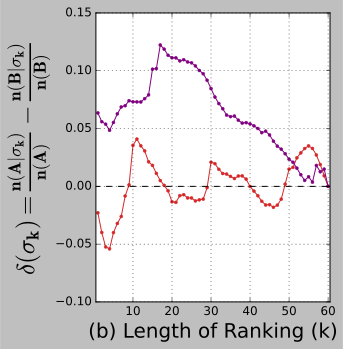

In [61]:
fig, ax = plt.subplots(figsize=(5,5))
offset=0.5
colorMap=['tab:red', 'tab:green', 'tab:blue', 'tab:orange', 'tab:grey', 'tab:brown', 'tab:olive', 'tab:pink']
alg_list=[EO_RankerII, Uniform_Ranker]
for i, alg in enumerate(rankingAlgos):
    if alg in [EO_RankerII]:
        ax.plot(np.arange(1, eo_constraint_arr.shape[2]+1), np.sum(eo_constraint_arr[i,:,:], axis=0)/num_queries, label=f"{alg.name()}", marker='.', c=colorMap[i])
ax.plot(np.arange(1, eo_constraint_actual.shape[2]+1), np.sum(eo_constraint_actual[0,:,:], axis=0)/num_queries, label=f"Logged Ranking", marker='.', c='purple')

plt.hlines(y=0, xmin=0, xmax=eo_constraint_arr.shape[2], color='black', linestyle='dashed')

plt.grid()
plt.ylabel(r'$\bf{\delta(\sigma_k) = \frac{n(A|\sigma_k) }{n(A)}- \frac{n(B|\sigma_k)}{n(B)}}$', fontsize=25)
plt.xlabel("(b) Length of Ranking (k)", fontsize=20)
plt.xlim(1-offset, eo_constraint_arr.shape[2]+offset)


plt.tight_layout()
plt.savefig(f"{osp.join('/share/thorsten/rr568/CostOptimal_FairRankings/plots/esci',f'markup_EO_{sim}.pdf')}", bbox_inches='tight')
plt.show()
plt.close()